# The Machine Learning Workflow Annotated

Source: [Pytorch / Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)

```{attention} TODO

- [ ] Understand the structure of the dataset
- [ ] Represent its contents appropriately
- [ ] Understand the dataset loading options
- [ ] Load an existing neural network model
- [ ] Use it for classification
- [ ] Use it in batched mode
- [ ] Evaluate the confidence in its answers
- [ ] Understand the components it uses
- [ ] Get the model parameters
- [ ] Replicate manually its computation
- [ ] Understand the loss function concept
- [ ] Understand what cross-entropy computes
- [ ] Understand what data loader does (at a high-level)
- [ ] Understand what the training loop does (at a high-level)
- [ ] Estimate model accuracy
- [ ] Save a model
```

In [1]:
import torch
import torchvision

## The FashionMNIST Dataset 

In [2]:
# Download training data from open datasets.
training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

# Download test data from open datasets.
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

In [3]:
# by default: training data set, no input/output transform, no download
data = torchvision.datasets.FashionMNIST(root="data") 
data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

In [4]:
# data is list-like ; each item in an input-output pair
datum = data[0]
datum

(<PIL.Image.Image image mode=L size=28x28>, 9)

In [5]:
image, index = datum

In [6]:
image

In [7]:
# The output is a number that denotes the class of the pictured object. 
# The list of classes is:
print(data.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
# Get the category name from the index:
data.classes[index] # that checks out!

'Ankle boot'

In [9]:
import pandas as pd
df = [{"image": image, "class": data.classes[index]} for image, index in data]
df = pd.DataFrame(df)
df

,image,class
0,<PIL.Image.Image image mode=L size=28x28 at 0x...,Ankle boot
1,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top
2,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top
3,<PIL.Image.Image image mode=L size=28x28 at 0x...,Dress
4,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top
...,...,...
59995,<PIL.Image.Image image mode=L size=28x28 at 0x...,Sandal
59996,<PIL.Image.Image image mode=L size=28x28 at 0x...,Trouser
59997,<PIL.Image.Image image mode=L size=28x28 at 0x...,Dress
59998,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top


In [10]:
df.head()

,image,class
0,<PIL.Image.Image image mode=L size=28x28 at 0x...,Ankle boot
1,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top
2,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top
3,<PIL.Image.Image image mode=L size=28x28 at 0x...,Dress
4,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top


In [11]:
import base64
import io
from IPython.display import HTML

def image_formatter(image):
    with io.BytesIO() as buffer:
        image.save(buffer, "jpeg")
        _bytes = buffer.getvalue()
    _base64 = base64.b64encode(_bytes).decode("ascii")
    return f'<img src="data:image/jpeg;base64, {_base64}">'

HTML(df.head().to_html(formatters={'image': image_formatter}, escape=False))

,image,class
0,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+tbw1oNx4m8QWmkWx2yXD4LkZCADJJ+gFbviL4a63oc7COE3MW4hdn38duD976jNc9daDqllIsc9lKrMu4YGeMkdR7gj8KzcV7H8BtEvV16+1iWCeG1Wz8mOV02pIzupwCeuAp6Z98cZ90aIzLIlw0c0ZJ4KgjHoeOa+evjS9n/wnMcNxBPCYLKONFhA2FNzMpGenDcgd816V4K03wefC+m3NlpVhP+5QSXBiR5fMx825iMg5zwce3FdbOzTwgW90lu6uCm8eYrL02soIyCPQgggEdMGQ3cluiPNK0rJwrRQBNueuMkt+teNfGKxsdY8WWdxNqcNo66eieXMwVsb5DnH415Hp2rajpE5n02/urOUjBe3laMkehIPIrVm8eeLrhNknibVivoLtx/I1UPinxC3XXtUP1vJP8ay5JZJpGkldnduSzHJP41//2Q=="">",Ankle boot
1,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/AOB+E3gyz8V6xez6lE01jYRqWiDFQ8jk7QSOcYVjxjoK9hlufDultLpcPhSa5itZdjra6NFNCshiEh5Yj5tmCTTjpvhnxg9zYX/huSCe3SMyLeWC20yI+7aUZTnb8jcA446V81a7pcmh69qGlytue0uHh3f3gpIB/Ec/jXSeBfiJf+CvMt7ezsp7a4lV5vORg/HHDKR2z1z1NfQF94U8Oapez3l7o9vczzkGSSR5MvjAGcMB0C9B2rC8Uz2Xw28LXGp+HdIsoJ5JIoCr+YyNyx5y2eMtjBHJr5517WrrxFrdzq16sS3FwwLiJdqjAAGB9AKzq+zkXjAAGcnivP8A4zLu8ATf7N1C/wCrD+tfONFfUf8AwlV5AmBbWrbQACwf0Ho1cV8S/Edzqfg66t5be2RTLFzGHzw2e7GvEa//2Q=="">",T-shirt/top
2,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+vX/DGqaVa6HZw6r4X07VQIFMLyxqrpkZIJ2/MM5P4nrXH+PZUuLu0njs7a0VlcLDbRBERQRhRgc49fc1yFFenaeANMsx6QRj/wAdFc/41H7uwOOcyc+3yf8A165GivUbVSlnAh6rEgP/AHyKwPGa7rK0fH3JGHX1A/wrjaK6zRPEN5Ni2mWKQImA7Kdxx6kGsfWdXudSmEc2xY4idqRjAz6nPJNZdf/Z"">",T-shirt/top
3,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APHfBp0z/hKLRdWSNrd22KZseWrnhS4PG3PXPHc8A17c95bWoiiawsW8n/VK9oj+Uf8AZ4+X8K434kXmnXOjGe9t4n1CZgttKiBZMjqS2MlQD0Oeo6da8lor3OZzeQWsqFGZ7dCwEijB2D34rg/iIXM2nbiCPLfowIByCeh9MVxFaGh2iX+uWVtIu6N5V3r6qOSPyBr1eS1iklWZoIWdoppM+WOQFBB6fWs7xzpUUnhiSWKFFNrLn5VA29PTsVZPyFeU1c0vUZdJ1GK9gSN5It20SAleVI7EetdHJ441P7NbuILMGOLygAjYKkMv970qvqPjrVdTsLi0mitEW4wJHjjIY4VV9cdFHauYr//Z"">",Dress
4,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+vp6f4feFNcg0LUIfDdlsleJrrypGgAt2iZtwVGUFg5TsSRn8PJ/jTYWGm+NbeDTrK2tIfsEbGO2iWNSxZ+cDvjAz

In [12]:
# Pytorch only want to deal with numeric array called "tensors", not images.
# So, we need to transform the input
image_to_tensor = torchvision.transforms.ToTensor()
t = image_to_tensor(image)
t

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [13]:
t.shape, t.dtype

(torch.Size([1, 28, 28]), torch.float32)

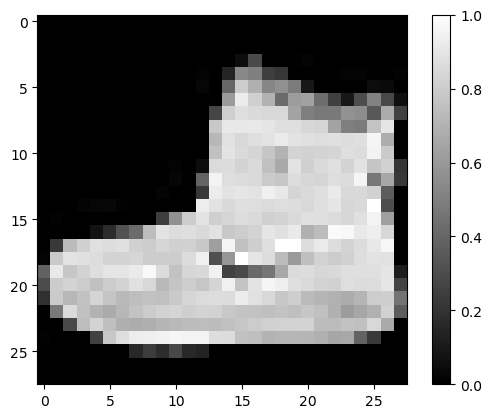

In [14]:
# No information has been lost in the conversion process!
import matplotlib.pyplot as plt
plt.imshow(t.squeeze(), cmap="grey")
plt.colorbar()
None

## Neural Network Model

The model architecture is going to assign to each image input the vector of probability $p_i$ that the item belongs to the $i$th class.
The class prediction is simply the class with the highest probability, but the fact that all $p_i$ are known allows us to evaluate the trust that we should have in the prediction.

The nitty-gritty details: the model does actually not output the probabilities $p_i \in [0, 1]$ directly but the corresponding unnormalized log probabilities
    $$
    \ell_i := \log p_i + c
    $$
because any value in $\mathbb{R}^{10}$ can be interpreted as vector of unnormalized log probabilies, this parameter is "free", devoid of constraints, in $\mathbb{R}^{10}$, so every possible output of or neural network is a valid value,
while the vector of probabilities is constrained.

If needed, compute $p_i$ with:
    $$
    p_i = \frac{\exp \ell_i}{\sum_{j=0}^{9} \exp \ell_j}.
    $$
The pytorch [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html) function implements this operation.

In [15]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_1 = torch.nn.Linear(28*28, 512)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(512, 512)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(512, 10)

    def forward(self, image_tensor):
        image_flat = self.flatten(image_tensor)
        x_0 = image_flat
        x_1 = self.linear_1(x_0)
        x_1 = self.relu_1(x_1)
        x_2 = self.linear_2(x_1)
        x_2 = self.relu_2(x_2)
        x_3 = self.linear_3(x_2)
        logits = x_3
        return logits

In [16]:
model = NeuralNetwork()
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=784, out_features=512, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=512, out_features=512, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=512, out_features=10, bias=True)
)

In [17]:
# Load the (trained) model state for this architecture
model.load_state_dict(torch.load("models/base-model.pth"))

<All keys matched successfully>

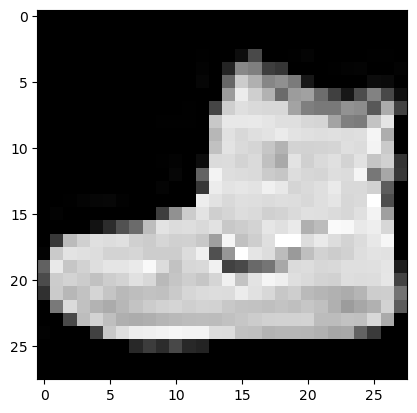

In [18]:
image_tensor, cls = training_data[0]
plt.imshow(image_tensor.squeeze(), cmap="grey")
plt.grid(False)
None

In [86]:
with torch.no_grad():
    logits = model(image_tensor)
logits = logits.squeeze()
logits

tensor([-5.0098, -6.9045, -5.7581, -6.5555, -3.8095,  8.2592, -4.7232,  8.2387,
         4.5910, 13.0613])

In [20]:
probas = torch.nn.functional.softmax(logits, dim=-1)
probas

tensor([8.0939e-07, 4.3064e-09, 1.0153e-05, 2.6920e-06, 3.0927e-05, 1.0618e-01,
        2.1777e-05, 1.0155e-02, 2.1407e-02, 8.6219e-01])

In [21]:
probas_dict = {training_data.classes[i]: p.item() for i, p in enumerate(probas)}
probas_dict

{'T-shirt/top': 8.093874157566461e-07,
 'Trouser': 4.306432099809854e-09,
 'Pullover': 1.0152617505809758e-05,
 'Dress': 2.691969712032005e-06,
 'Coat': 3.0927330954000354e-05,
 'Sandal': 0.10618074238300323,
 'Shirt': 2.177722126361914e-05,
 'Sneaker': 0.010154898278415203,
 'Bag': 0.021406900137662888,
 'Ankle boot': 0.8621910810470581}

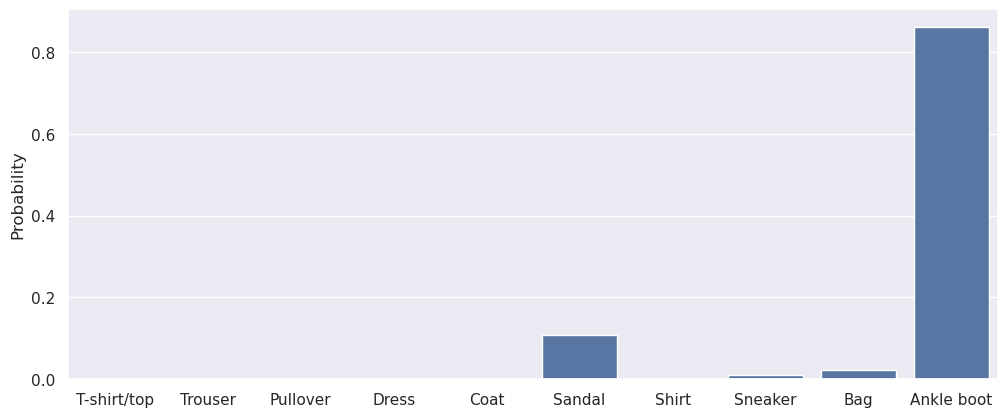

In [22]:
import seaborn as sns; sns.set_theme()
sns.barplot(probas_dict)
plt.gcf().set_figwidth(12)
plt.gca().set_ylabel("Probability")
None

### Batched Prediction

In [81]:
images = []
for i, (image, _) in enumerate(training_data):
    if i >= 10:
        break
    images.append(image)
images_tensor = torch.cat(images)
images_tensor

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [85]:
with torch.no_grad():
    output = model(images_tensor)
output

tensor([[ -5.0098,  -6.9045,  -5.7581,  -6.5555,  -3.8095,   8.2592,  -4.7232,
           8.2387,   4.5910,  13.0613],
        [ 13.2679,  -0.2590,   6.0235,   6.0931,  -0.6164,  -8.7820,   9.4116,
         -15.4555,   1.4393,  -7.7494],
        [  2.3625,   2.8809,   1.3259,   3.0747,   1.6546,  -3.2200,   1.5435,
          -3.7435,  -1.3179,  -3.1827],
        [  5.3274,   3.7790,   3.8660,   4.4635,   1.9559,  -5.5573,   3.9970,
          -8.0819,  -1.3923,  -6.1908],
        [  4.6780,   5.4077,   1.4708,   7.3867,   2.5110,  -7.7163,   1.7578,
          -6.4822,  -0.6809,  -5.6036],
        [  3.6292,   2.9155,   9.8322,   2.3858,   5.9549,  -4.4987,   6.1688,
         -13.5867,   1.1669,  -9.9658],
        [ -4.4626,  -2.6850,  -4.0493,  -3.8174,  -2.2163,   7.0781,  -4.3375,
           9.3105,   1.9777,   4.0626],
        [  2.2398,   1.9593,   9.5340,  -0.2489,   9.1338,  -4.6909,   7.2406,
         -13.9914,   3.4920,  -9.4693],
        [ -0.5928,  -2.7863,  -1.7774,  -1.5365,

### Parameters

In [69]:
for p in model.parameters():
    print(f"type: {type(p.data).__name__}, shape: {tuple(p.shape)!s:<10}, data type: {p.dtype}")

type: Tensor, shape: (512, 784), data type: torch.float32
type: Tensor, shape: (512,)    , data type: torch.float32
type: Tensor, shape: (512, 512), data type: torch.float32
type: Tensor, shape: (512,)    , data type: torch.float32
type: Tensor, shape: (10, 512) , data type: torch.float32
type: Tensor, shape: (10,)     , data type: torch.float32


```{tip} Model Size
How many scalar parameters describe the model? What is the corresponding model size in MB?
```

In [70]:
num_params = 0
for p in model.parameters():
    num_params += torch.prod(torch.tensor(p.shape)).item()

There are {eval}`num_params` ($\approx$ {eval}`num_params // 1_000`K) parameters in the model. The size of each parameter is 4B, hence the total size is {eval}`round(num_params * 4 / 1_000_000, 1)`MB.

### Predictor

In [25]:
with torch.no_grad():
    to_tensor = torchvision.transforms.ToTensor()
    input = to_tensor(image)
    output = model(input)
output

tensor([[ -5.0635, -10.2997,  -2.5343,  -3.8617,  -1.4204,   6.7209,  -1.7712,
           4.3737,   5.1194,   8.8152]])

In [26]:
logits = output.data
probas = torch.nn.functional.softmax(logits, dim=-1)
probas = probas.squeeze()
probas

tensor([8.0939e-07, 4.3064e-09, 1.0153e-05, 2.6920e-06, 3.0927e-05, 1.0618e-01,
        2.1777e-05, 1.0155e-02, 2.1407e-02, 8.6219e-01])

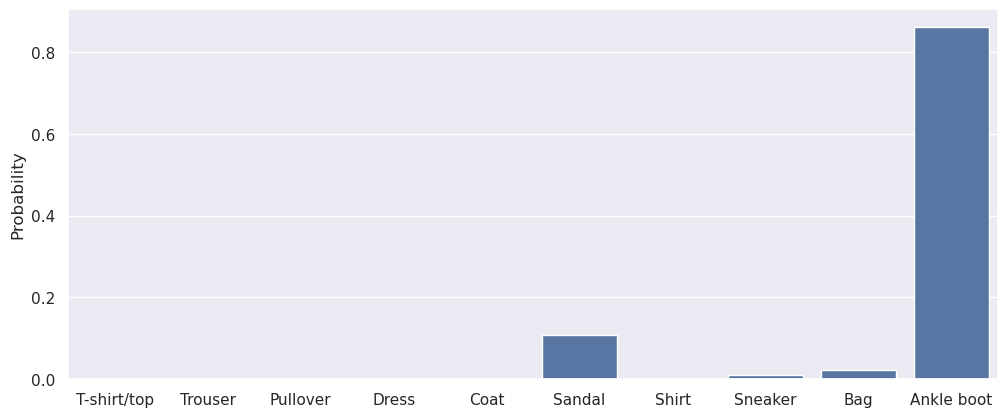

In [27]:
import seaborn as sns; sns.set_theme()
probas_dict = {training_data.classes[i]: p.item() for i, p in enumerate(probas)}
sns.barplot(probas_dict)
plt.gcf().set_figwidth(12)
plt.gca().set_ylabel("Probability")
None

In [28]:
def prediction(image):
    to_tensor = torchvision.transforms.ToTensor()
    model.eval()
    with torch.no_grad():
        input = to_tensor(image)
        output = model(input)
    logits = output.data.squeeze()
    probas = torch.nn.functional.softmax(logits, dim=-1)
    class_proba = {training_data.classes[i]: p.item() for i, p in enumerate(probas)}
    key = max(class_proba, key=class_proba.get)
    return key

In [29]:
prediction(image)

('Ankle boot',
 {'T-shirt/top': 8.093874157566461e-07,
  'Trouser': 4.306432099809854e-09,
  'Pullover': 1.0152617505809758e-05,
  'Dress': 2.691969712032005e-06,
  'Coat': 3.0927330954000354e-05,
  'Sandal': 0.10618074238300323,
  'Shirt': 2.177722126361914e-05,
  'Sneaker': 0.010154898278415203,
  'Bag': 0.021406900137662888,
  'Ankle boot': 0.8621910810470581})

### Under the Hood

#### Flatten

In [30]:
model.flatten

Flatten(start_dim=1, end_dim=-1)

In [31]:
image

In [32]:
t = torchvision.transforms.ToTensor()(image)
t

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [33]:
model.flatten(t)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
         0.0510, 0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0039, 0.0

#### Linear (Affine) Operator

In [34]:
model.linear_1

Linear(in_features=784, out_features=512, bias=True)

In [111]:
linop = torch.nn.Linear(1, 2)
linop.weight, linop.bias

(Parameter containing:
 tensor([[0.1496],
         [0.4472]], requires_grad=True),
 Parameter containing:
 tensor([-0.8151,  0.7930], requires_grad=True))

In [137]:
list(linop.parameters())

[Parameter containing:
 tensor([[0.1496],
         [0.4472]], requires_grad=True),
 Parameter containing:
 tensor([-0.8151,  0.7930], requires_grad=True)]

In [134]:
input = torch.linspace(0.0, 5.0, 6)
input

tensor([0., 1., 2., 3., 4., 5.])

In [135]:
with torch.no_grad():
    input_t = input.reshape(1, -1, 1)
    output_t = linop(input_t)
output = output_t.squeeze()

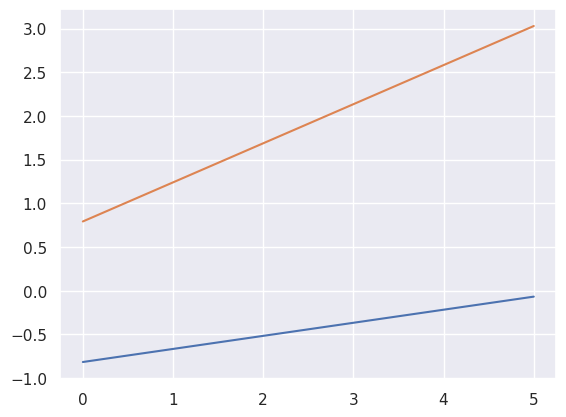

In [136]:
plt.plot(input, output)
None

In [35]:
model.linear_1.in_features == 28 * 28

True

In [36]:
linear_1_params = {name: param.data for name, param in model.linear_1.named_parameters()}
linear_1_params

{'weight': tensor([[ 0.0210, -0.0154,  0.0339,  ...,  0.0224, -0.0339, -0.0155],
         [ 0.0280,  0.0130, -0.0151,  ..., -0.0192, -0.0073,  0.0151],
         [-0.0329, -0.0160,  0.0025,  ...,  0.0269, -0.0198, -0.0071],
         ...,
         [-0.0168,  0.0145,  0.0017,  ...,  0.0345,  0.0356,  0.0282],
         [-0.0032, -0.0066,  0.0123,  ...,  0.0290, -0.0179,  0.0212],
         [ 0.0287,  0.0198, -0.0294,  ..., -0.0113, -0.0313, -0.0064]]),
 'bias': tensor([ 5.1996e-03, -1.2248e-02,  4.4100e-03,  1.1871e-02, -3.1891e-03,
          4.9179e-02,  3.2756e-02,  2.3313e-02, -5.2828e-03, -5.9944e-03,
          4.9043e-03,  2.8898e-02, -5.3561e-03,  4.2246e-04, -1.4582e-02,
          9.8977e-03, -1.4168e-02, -3.5468e-02,  6.6746e-03, -2.8466e-02,
         -3.5134e-02, -3.5082e-02, -1.8402e-03,  1.4411e-02, -9.7980e-03,
         -2.7347e-02,  6.5316e-04, -9.9767e-03, -2.4916e-02, -1.1855e-02,
          4.0395e-02,  2.6589e-02,  3.7311e-02, -5.5242e-03,  1.0600e-02,
          2.8209e-02, 

In [37]:
b1 = linear_1_params["bias"]
b1.shape

torch.Size([512])

In [38]:
A1 = linear_1_params["weight"]
A1.shape

torch.Size([512, 784])

In [39]:
to_tensor = torchvision.transforms.ToTensor() 
t = to_tensor(image)
print(t.shape)
tf = torch.flatten(t)
print(tf.shape)
x1 = A1 @ tf + b1
x1

torch.Size([1, 28, 28])
torch.Size([784])


tensor([ 8.8665e-01,  1.0730e-01,  7.7226e-01,  2.7048e-02,  4.3016e-01,
         1.5970e-01,  1.4650e+00,  1.1446e-01,  7.1368e-01, -3.4731e-01,
        -2.5061e-01,  4.1906e-01,  5.0979e-01, -1.0190e-01,  6.1584e-01,
        -3.1647e-02,  2.9027e-01,  8.0485e-01,  1.0404e+00,  1.4717e+00,
        -2.0144e-01, -4.9204e-01,  4.3049e-01,  8.1608e-01,  5.7509e-01,
         4.1380e-01, -1.3215e-01,  1.3625e+00,  7.0342e-01, -3.6172e-01,
         1.5684e-01,  1.1166e-01, -2.5141e-02,  1.6572e-02,  1.2301e+00,
         4.6730e-02,  3.5725e-01,  1.6392e+00, -1.2866e-01,  5.1656e-02,
        -1.2716e-01,  1.1330e+00,  4.8189e-01,  4.6777e-01,  1.0565e-01,
         7.0828e-02, -1.3844e-01,  5.4397e-01,  7.3986e-01,  1.1406e+00,
         4.2778e-01, -1.0022e-02,  1.7495e+00,  5.9266e-01, -3.2583e-01,
         1.5128e+00,  1.6304e-01,  1.4116e-02,  7.0362e-01, -6.4304e-02,
        -6.7409e-01,  4.8112e-01,  6.2921e-01,  4.6251e-01,  1.0056e+00,
        -2.5652e-01,  9.0090e-01, -4.2083e-01,  6.5

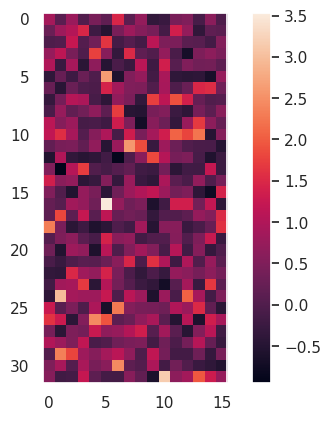

In [40]:
plt.imshow(x1.reshape((2**5, 2**4)))
plt.grid(False)
plt.colorbar()
None

### Rectified Linear Unit

In [41]:
x1 = model.relu_1(x1)
x1

tensor([8.8665e-01, 1.0730e-01, 7.7226e-01, 2.7048e-02, 4.3016e-01, 1.5970e-01,
        1.4650e+00, 1.1446e-01, 7.1368e-01, 0.0000e+00, 0.0000e+00, 4.1906e-01,
        5.0979e-01, 0.0000e+00, 6.1584e-01, 0.0000e+00, 2.9027e-01, 8.0485e-01,
        1.0404e+00, 1.4717e+00, 0.0000e+00, 0.0000e+00, 4.3049e-01, 8.1608e-01,
        5.7509e-01, 4.1380e-01, 0.0000e+00, 1.3625e+00, 7.0342e-01, 0.0000e+00,
        1.5684e-01, 1.1166e-01, 0.0000e+00, 1.6572e-02, 1.2301e+00, 4.6730e-02,
        3.5725e-01, 1.6392e+00, 0.0000e+00, 5.1656e-02, 0.0000e+00, 1.1330e+00,
        4.8189e-01, 4.6777e-01, 1.0565e-01, 7.0828e-02, 0.0000e+00, 5.4397e-01,
        7.3986e-01, 1.1406e+00, 4.2778e-01, 0.0000e+00, 1.7495e+00, 5.9266e-01,
        0.0000e+00, 1.5128e+00, 1.6304e-01, 1.4116e-02, 7.0362e-01, 0.0000e+00,
        0.0000e+00, 4.8112e-01, 6.2921e-01, 4.6251e-01, 1.0056e+00, 0.0000e+00,
        9.0090e-01, 0.0000e+00, 6.5264e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.1133e+00, 0.0000e+00, 1.3664e+

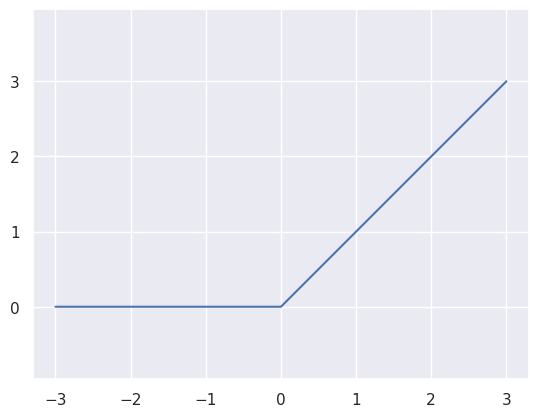

In [142]:
relu = torch.nn.ReLU()
input = torch.linspace(-3.0, 3.0, 7)
relu(input)
plt.plot(input, relu(input))
plt.axis("equal")
None

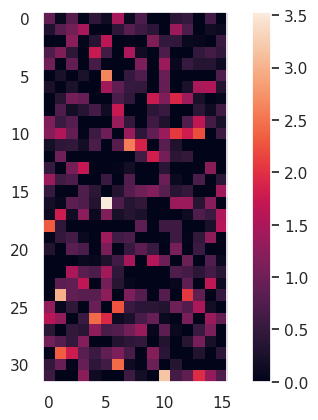

In [42]:
plt.imshow(x1.reshape((2**5, 2**4)))
plt.grid(False)
plt.colorbar()
None

In [43]:
list(model.relu_1.named_parameters())

[]

In [44]:
linear_2_params = {name: param.data for name, param in model.linear_2.named_parameters()}
A2 = linear_2_params["weight"]
b2 = linear_2_params["bias"]
x2 = A2 @ x1 + b2
x2

tensor([ 4.5193e-02,  2.4715e-01, -5.3508e-02, -3.3197e-02, -5.5402e-01,
         1.7423e-01, -3.8955e-01, -8.8696e-02, -4.0643e-01,  1.6696e+00,
        -2.0191e-01,  3.8550e-01,  4.1091e-01,  2.0389e-01,  1.1615e+00,
         5.0936e-01,  1.5187e+00,  1.8550e+00,  3.9364e-01, -6.1430e-01,
        -3.1030e-01, -3.7026e-01, -9.3385e-02, -5.0093e-01,  1.4686e-01,
        -3.8066e-01,  2.9109e-01,  2.4518e-01,  1.2068e-01,  9.7248e-02,
         1.9590e-01,  8.9326e-01, -4.4031e-01,  1.1948e+00,  2.0032e+00,
        -1.4473e+00,  1.7262e-04, -2.6927e-01, -2.4689e-01,  1.2692e+00,
        -6.7922e-01,  7.6290e-01,  3.2575e-01,  8.8438e-01,  7.4264e-01,
         4.0632e-02,  4.1165e-01,  4.3593e-01,  4.3277e-01, -2.4731e-01,
         1.1617e+00,  1.5220e+00,  1.3802e-01,  1.2317e+00,  7.9711e-01,
         1.2756e+00, -6.2532e-01,  2.8061e-01,  4.1382e-01,  3.8979e-01,
         1.1157e-01,  1.3655e+00,  5.7564e-01, -1.8827e-01,  1.4302e+00,
         4.6465e-01,  1.3133e-01,  9.5735e-01,  1.5

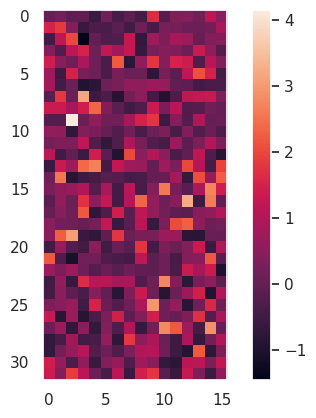

In [45]:
plt.imshow(x2.reshape((2**5, 2**4)))
plt.grid(False)
plt.colorbar()
None

In [46]:
x2 = model.relu_2(x2)
x2

tensor([4.5193e-02, 2.4715e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7423e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6696e+00, 0.0000e+00, 3.8550e-01,
        4.1091e-01, 2.0389e-01, 1.1615e+00, 5.0936e-01, 1.5187e+00, 1.8550e+00,
        3.9364e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.4686e-01, 0.0000e+00, 2.9109e-01, 2.4518e-01, 1.2068e-01, 9.7248e-02,
        1.9590e-01, 8.9326e-01, 0.0000e+00, 1.1948e+00, 2.0032e+00, 0.0000e+00,
        1.7262e-04, 0.0000e+00, 0.0000e+00, 1.2692e+00, 0.0000e+00, 7.6290e-01,
        3.2575e-01, 8.8438e-01, 7.4264e-01, 4.0632e-02, 4.1165e-01, 4.3593e-01,
        4.3277e-01, 0.0000e+00, 1.1617e+00, 1.5220e+00, 1.3802e-01, 1.2317e+00,
        7.9711e-01, 1.2756e+00, 0.0000e+00, 2.8061e-01, 4.1382e-01, 3.8979e-01,
        1.1157e-01, 1.3655e+00, 5.7564e-01, 0.0000e+00, 1.4302e+00, 4.6465e-01,
        1.3133e-01, 9.5735e-01, 1.5263e-01, 0.0000e+00, 2.2079e+00, 0.0000e+00,
        5.6939e-01, 1.7802e+00, 4.4257e-

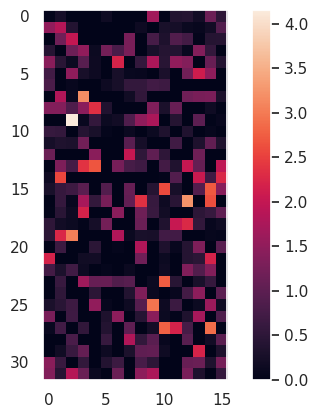

In [47]:
plt.imshow(x2.reshape((2**5, 2**4)))
plt.grid(False)
plt.colorbar()
None

In [48]:
linear_3_params = {name: param.data for name, param in model.linear_3.named_parameters()}
A3 = linear_3_params["weight"]
b3 = linear_3_params["bias"]
x3 = A3 @ x2 + b3
x3

tensor([ -5.0635, -10.2997,  -2.5343,  -3.8617,  -1.4204,   6.7209,  -1.7712,
          4.3737,   5.1194,   8.8152])

In [49]:
def softmax(x):
    return torch.nn.functional.softmax(x, dim=0)

probas = softmax(x3)
probas

tensor([8.0939e-07, 4.3064e-09, 1.0153e-05, 2.6920e-06, 3.0927e-05, 1.0618e-01,
        2.1777e-05, 1.0155e-02, 2.1407e-02, 8.6219e-01])

In [50]:
data = {training_data.classes[i]: p.item() for i, p in enumerate(probas)}
data

{'T-shirt/top': 8.093874157566461e-07,
 'Trouser': 4.306432099809854e-09,
 'Pullover': 1.0152617505809758e-05,
 'Dress': 2.691969712032005e-06,
 'Coat': 3.0927330954000354e-05,
 'Sandal': 0.10618074238300323,
 'Shirt': 2.177722126361914e-05,
 'Sneaker': 0.010154898278415203,
 'Bag': 0.021406900137662888,
 'Ankle boot': 0.8621910810470581}

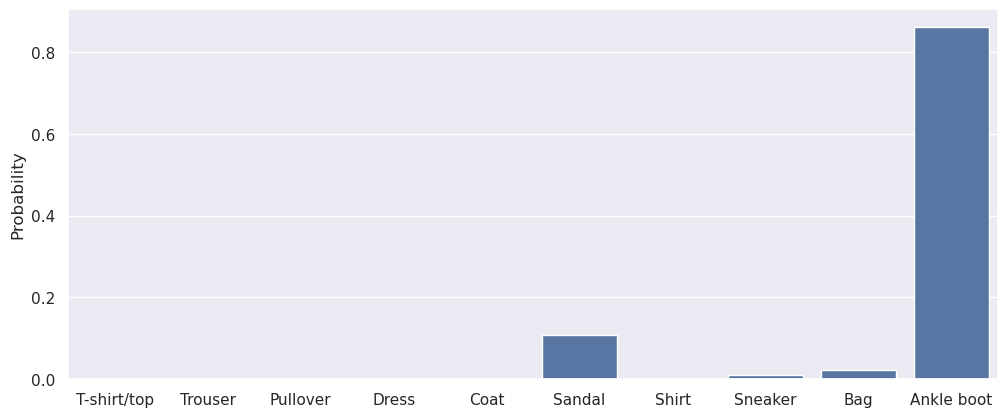

In [51]:
import seaborn as sns; sns.set_theme()
sns.barplot(data)
plt.gcf().set_figwidth(12)
plt.gca().set_ylabel("Probability")
None

In [52]:
out = model(t).data.squeeze()

In [53]:
ps = torch.nn.functional.softmax(out, dim=-1)

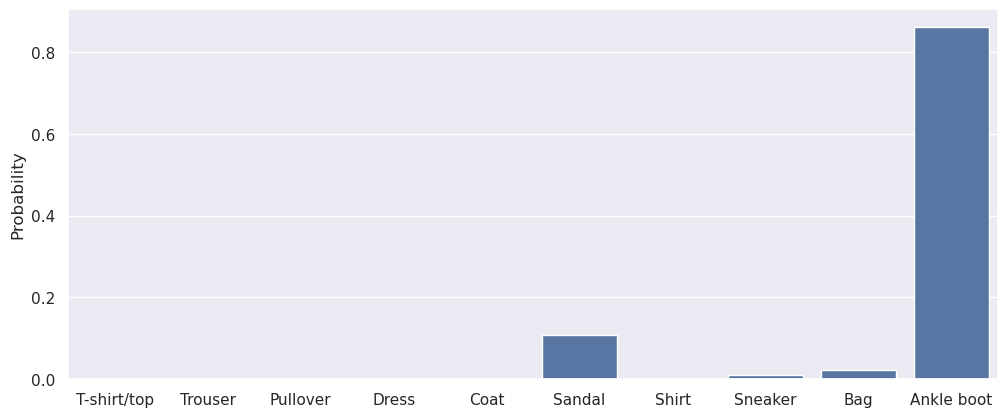

In [54]:
data = {training_data.classes[i]: p.item() for i, p in enumerate(ps)}
sns.barplot(data)
plt.gcf().set_figwidth(12)
plt.gca().set_ylabel("Probability")
None

## Training

### Loss Function

The loss function is a measure of the model prediction error: the mismatch between the output predicted by the model and the "real" output. Here, in the context of category identification, we use the cross-entropy loss function.

In [55]:
loss_function = torch.nn.CrossEntropyLoss()

It measures the differences between two probability distributions: here a computed probability distribution $p=(p_0, \dots, p_{n-1})$ and a "deterministic" distribution $q=e_i$ with
$$
e_i=(0, \dots, 0, 1, 0, \dots, 0) \;\;\; \mbox{($1$ in position $i$)}
$$
with:
$$
\mathrm{loss}(p, e_i) = - \log p_i. 
$$
The loss is zero when $p_i = 1$ (perfect match) and $-\infty$ when $p_i = 0$. It does not depend on the distribution of the $p_j$ for $j \neq i$.

```{warning}
The pytorch cross entropy function works directly with unnormalized log probabilities 
$$
\ell_i := \log p_i + c
$$
(the log probabilities up to a shared constant $c$) instead of the probabilites $p$. 
The deterministic distribution is also specified by the index $i$ instead of the vector $q=e_i$.
Hence, it actually computes
$$
\mathrm{loss}(\ell, i) := -\ell_i  + \log \left( \sum_je^{\ell_j} \right). 
$$
```


In [56]:
cross_entropy = torch.nn.CrossEntropyLoss()

In [57]:
cross_entropy(
    input=torch.tensor([1.0, 0.0]).log(), 
    target=torch.tensor(0)
)

tensor(0.)

In [58]:
cross_entropy(
    input=torch.tensor([0.0, 1.0]).log(), 
    target=torch.tensor(0)
)

tensor(inf)

In [59]:
cross_entropy(
    input=torch.tensor([0.5, 0.5]).log(), 
    target=torch.tensor(0)
)

tensor(0.6931)

In [60]:
- torch.tensor(0.5).log()

tensor(0.6931)

In [61]:
cross_entropy(
    input=torch.tensor([2/3, 1/3]).log(), 
    target=torch.tensor(0)
)

tensor(0.4055)

In [62]:
cross_entropy(
    input=torch.tensor([200.0, 100.0]).log(), 
    target=torch.tensor(0)
)

tensor(0.4055)

### Data Loader

In [63]:
batch_size = 64

# Create data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"X = [N, C, H, W]: {X.shape}")
    print(f"y: {y.shape} {y.dtype}")
    break

X = [N, C, H, W]: torch.Size([64, 1, 28, 28])
y: torch.Size([64]) torch.int64


### Training

In [64]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [65]:
def test(dataloader, model, loss_fn):
    """
    Returns:
      - score, the probability of a correct inference on the test dataset
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [66]:
model = NeuralNetwork()
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_function = torch.nn.CrossEntropyLoss()

score = 0.0
new_score = test(test_dataloader, model, loss_function)
epoch = 0
keep_learning = True
while keep_learning:
    epoch += 1
    score = new_score
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_function, optimizer)
    new_score = test(test_dataloader, model, loss_function)
    keep_learning = new_score > score

print("Done!")


Test Error: 
 Accuracy: 9.95%, Avg loss: 2.303694 

Epoch 2
-------------------------------
loss: 2.304295  [   64/60000]
loss: 2.291619  [ 6464/60000]
loss: 2.275531  [12864/60000]
loss: 2.260639  [19264/60000]
loss: 2.244066  [25664/60000]
loss: 2.209937  [32064/60000]
loss: 2.210268  [38464/60000]
loss: 2.186495  [44864/60000]
loss: 2.178486  [51264/60000]
loss: 2.139348  [57664/60000]
Test Error: 
 Accuracy: 52.78%, Avg loss: 2.137757 

Epoch 3
-------------------------------
loss: 2.151297  [   64/60000]
loss: 2.140881  [ 6464/60000]
loss: 2.084896  [12864/60000]
loss: 2.093015  [19264/60000]
loss: 2.033889  [25664/60000]
loss: 1.974120  [32064/60000]
loss: 1.995442  [38464/60000]
loss: 1.926260  [44864/60000]
loss: 1.932283  [51264/60000]
loss: 1.841078  [57664/60000]
Test Error: 
 Accuracy: 60.60%, Avg loss: 1.846590 

Epoch 4
-------------------------------
loss: 1.885732  [   64/60000]
loss: 1.852837  [ 6464/60000]
loss: 1.736268  [12864/60000]
loss: 1.770142  [19264/60000]
lo

In [67]:
torch.save(model.state_dict(), "models/model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth
